## EDA: game ratings data 

### Springboard Capstone 2 project: building a recommendation engine
### John Burt


### Purpose of this notebook:

Explore the user ratings data. Is there anything unusual about the distribution of ratings?

#### The method:

- Load user-game ratings data into a pandas dataframe from provided csv files.

- Use pivot to convert the data into a games(rows) X users(cols) rating matrix, with NaNs where users haven't rated games (majority of cells).

- Analyze ratings by user and game


In [85]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

## Load ratings and game ID data from csv files


In [90]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

from datetime import datetime

pd.options.display.max_rows = 100

srcdir = './data/'

# load the boardgame user ratings data
userdata = pd.read_csv(srcdir+'bgg_user_ratings_scrape_1.csv', 
# userdata = pd.read_csv(srcdir+'bgg_user_ratings_v2.csv', 
                       encoding = "ISO-8859-1") 
userdata=userdata.rename(columns = {'username':'userID', 
                                    'gameid':'gameID'})
userdata = userdata.drop_duplicates(subset=['gameID','userID'])

# load the boardgame metadata
gameinfo = pd.read_csv(srcdir+'bgg_game_info.csv')

print('number of ratings =',userdata.shape[0])
print('number of users =',len(userdata['userID'].unique()))
print('number of games =',gameinfo.shape[0])

userdata.head()

number of ratings = 15687808
number of users = 301760
number of games = 12600


,gameID,userID,rating
0,13,sidehacker,10.0
1,13,Varthlokkur,10.0
2,13,dougthonus,10.0
3,13,cypar7,10.0
4,13,ssmooth,10.0


### User rating frequency histogram.

How many games do users rate, and what is the distribution of average user rating?

#### Hmmm.... There's something odd going on in the rating count histogram: there's an extra distribution of users rating > 4200 games. 


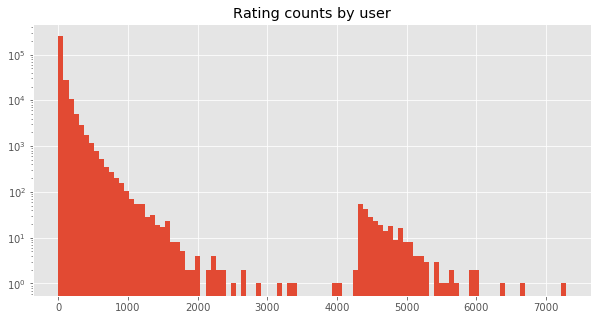

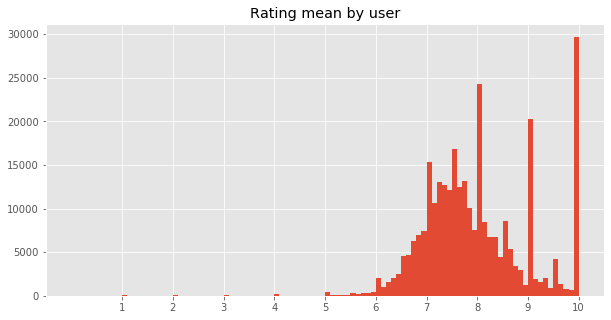

In [98]:
usergp = userdata.groupby('userID')

plt.figure(figsize=(10,5))
plt.hist(usergp['rating'].count(), bins=100)
plt.yscale('log')
# plt.xscale('log')
plt.title('Rating counts by user');
plt.gcf().patch.set_facecolor('white'); # white background for copy

plt.figure(figsize=(10,5))
plt.hist(usergp['rating'].mean(), bins=100)
plt.xticks([1,2,3,4,5,6,7,8,9,10])
# plt.yscale('log')
plt.title('Rating mean by user');
plt.gcf().patch.set_facecolor('white'); # white background for copy


### Game rating frequency histogram.

How many ratings do games receive, and what's the distribution of average game ratings?

#### Hmmm... There's something odd with the mean game rating frequencies: where I'd expect a single distribution, there are two, one centered at ~4.75 and another at ~7.

(12600,)


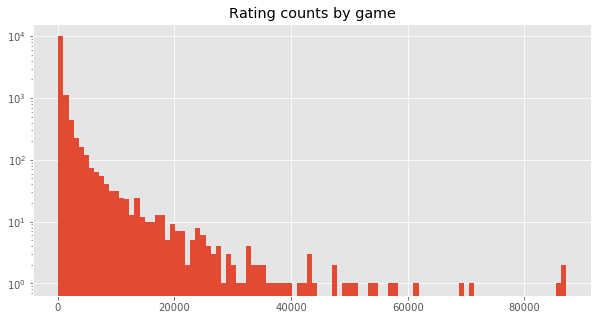

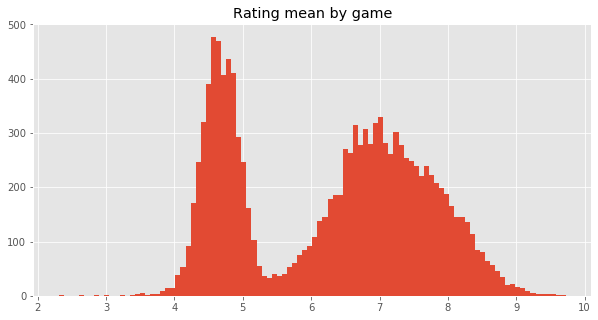

In [97]:
gamegp = userdata.groupby('gameID')

plt.figure(figsize=(10,5))
plt.hist(gamegp['rating'].count(), bins=100)
plt.yscale('log')
plt.title('Rating counts by game');
plt.gcf().patch.set_facecolor('white'); # white background for copy

plt.figure(figsize=(10,5))
plt.hist(gamegp['rating'].mean(), bins=100)
# plt.yscale('log')
plt.title('Rating mean by game');
plt.gcf().patch.set_facecolor('white'); # white background for copy

print(gamegp['rating'].mean().shape)

### Looking further at the mean game rating distributions

The mean game rating histogram shows two distributions: one at about 4.75, and the other at about 7.0.

How do these different groupings differ?

Since they have little overlap, I can can split them up using a rating threshold.

#### Looking at rating counts for games below vs. above threshold, I see that the below threshold games have a lot fewer ratings.

games_below.shape (4546, 2)
games_above.shape (8054, 2)


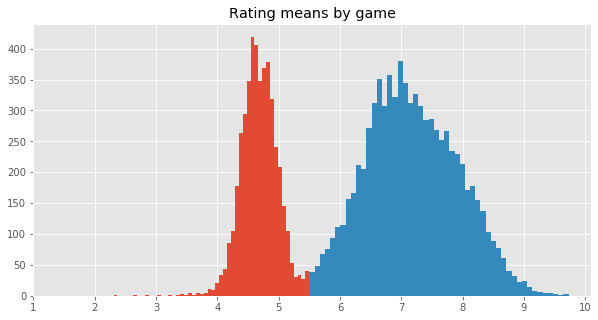

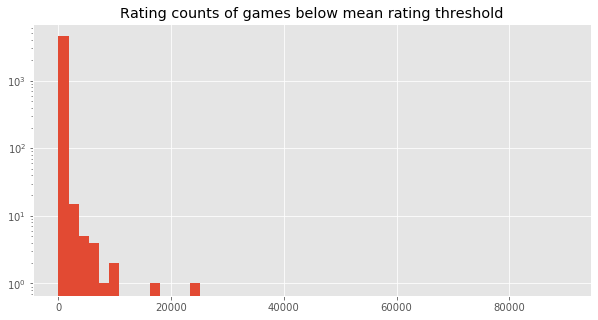

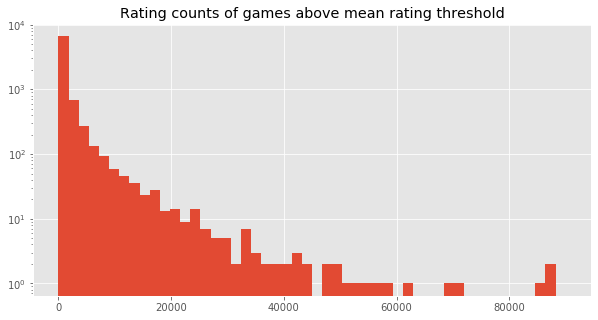

In [93]:
# rating threshold to split the distributions
max_rating = 5.5

# convert game mean rating grouping to dataframe
gm = gamegp.mean().reset_index()

# split user grouped data by # ratings per user
games_above = gm[gm['rating']>max_rating]
games_below = gm[gm['rating']<=max_rating]

print('games_below.shape',games_below.shape)
print('games_above.shape',games_above.shape)

# show histo by # user ratings - should be split at max_count threshold
plt.figure(figsize=(10,5))
plt.hist(games_below['rating'], bins=50)
plt.hist(games_above['rating'], bins=50)
plt.xticks([1,2,3,4,5,6,7,8,9,10])
# plt.yscale('log')
plt.title('Rating means by game');

# convert user grouping count to dataframe
gc = gamegp.count().reset_index().set_index('gameID')

# show histo by mean user ratings 
plt.figure(figsize=(10,5))
plt.hist(gc.loc[games_below['gameID']]['rating'], bins=50, range=[1,90000])
plt.yscale('log')
plt.title('Rating counts of games below mean rating threshold');

plt.figure(figsize=(10,5))
plt.hist(gc.loc[games_above['gameID']]['rating'], bins=50, range=[1,90000]);
# plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.yscale('log')
plt.title('Rating counts of games above mean rating threshold');


### Boardgamegeek mean game rating metadata

Helpfully, Boardgamegeek includes in its metadata their own measure of average game rating for all games. I have this as a feature column in the gameinfo dataframe.

What does the BGG mean game rating hist look like?

#### It is a single distribution centered at about 6.8. That roughly matches the upper distribution of mean game ratings in my scraped data. 

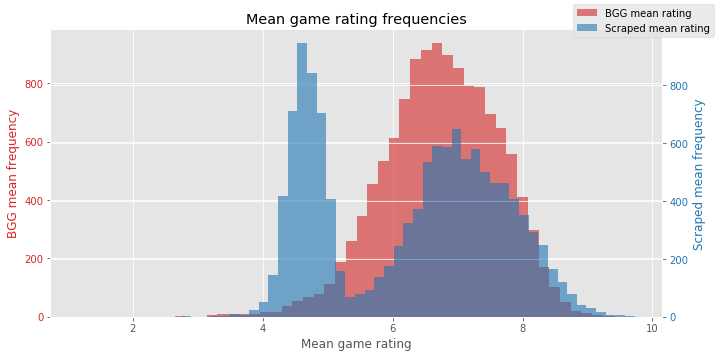

In [188]:
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('Mean game rating')
ax1.set_ylabel('BGG mean frequency', color=color)
ax1.hist(gameinfo['mean_rating'], bins=50, color=color,
         label='BGG mean rating', alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # create second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Scraped mean frequency', color=color)
ax2.hist(gamegp['rating'].mean(), bins=50, color=color,
         label='Scraped mean rating', alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Mean game rating frequencies');
fig.legend();

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.patch.set_facecolor('white'); # white background for copy


### Test similarity of distributions

Are either of the two mean game rating distributions from scraped data similar to the BGG ratings, which I assume are accurate?

I'll use a Kolmogorov-Smirnov test on two samples. The null hypothesis is that the samples are drawn from the same distribution.

Results:

When samples from the upper and lower scraped mean ratings distributions are tested against the BGG ratings distribution, they are found to be significantly different. 

The upper scraped distribution is very similar in shape and overlap to the BGG rating distribution, but the mean appears to be shifted slightly higher. I de-meaned the samples and ran the test again. This time, the upper scraped ratings were not significantly different from the BGG ratings, but the lower scraped ratings were still different.

Finally, I standardized the three distributions and tested them again. After standardizing the distributions, all were found to be not significantly different from each other.

My conclusion from this analysis:
- 1) The upper scraped ratings have very similar distribution as the BGG ratings, with a slight shift in rating level. This suggests that the upper scraped ratings are valid ratings.
- 2) The lower scraped ratings not only have a different mean from the BGG ratings, but unlike the upper set they have quite different variance. However, after all sample sets are standardized, they are not different. It appears that whatever process is affecting the lower scraped distribution of ratings, it is a linear one because it can be corrected by standardization.


In [209]:
from scipy import stats

def do_KStest(data1, data2):
    """Run a Kolmogorov-Smirnov test on two samples"""
    d, pval = stats.ks_2samp(data1, data2)
    print('  D = %1.4f, p-val = %1.5f'%(d, pval),'Result:',
         'not the same' if pval<=alpha else "the same")

nsamples = 500
alpha = 0.05

# take samples from each distribution
samps_bgg = gameinfo['mean_rating'].sample(nsamples)
samps_upper = games_above['rating'].sample(nsamples)
samps_lower = games_below['rating'].sample(nsamples)

print('\nComparing unmodified sample distributions:\n')

# Are the BGG mean ratings same dist as upper mean ratings?
print('Are the BGG mean ratings same dist as upper mean ratings?')
do_KStest(samps_bgg, samps_upper)

# Are the BGG mean ratings same dist as lower mean ratings?
print('\nAre the BGG mean ratings same dist as lower mean ratings?')
do_KStest(samps_bgg, samps_lower)

print('\n***********************************************')
print('BGG rating mean = %1.3f'%(samps_bgg.mean()))
print('Scraped upper dist rating mean = %1.3f'%(samps_upper.mean()))
print('Scraped lower dist rating mean = %1.3f'%(samps_lower.mean()))

print('\nAfter subtracting means:\n')

# Are the BGG mean ratings same dist as upper mean ratings?
print('Are the BGG mean ratings same dist as upper mean ratings?')
do_KStest(samps_bgg-samps_bgg.mean(), samps_upper-samps_upper.mean())

# Are the BGG mean ratings same dist as lower mean ratings?
print('\nAre the BGG mean ratings same dist as lower mean ratings?')
do_KStest(samps_bgg-samps_bgg.mean(), samps_lower-samps_lower.mean())

print('\n***********************************************')
print('BGG rating std = %1.3f'%(samps_bgg.std()))
print('Scraped upper dist rating std = %1.3f'%(samps_upper.std()))
print('Scraped lower dist rating std = %1.3f'%(samps_lower.std()))

print('\nAfter standardizing:\n')

# Are the BGG mean ratings same dist as upper mean ratings?
print('Are the BGG mean ratings same dist as upper mean ratings?')
do_KStest((samps_bgg-samps_bgg.mean())/samps_bgg.std(), 
          (samps_upper-samps_upper.mean())/samps_upper.std())

# Are the BGG mean ratings same dist as lower mean ratings?
print('\nAre the BGG mean ratings same dist as lower mean ratings?')
do_KStest((samps_bgg-samps_bgg.mean())/samps_bgg.std(), 
          (samps_lower-samps_lower.mean())/samps_lower.std())

# Are the upper mean ratings same dist as lower mean ratings?
print('\nAre the upper mean ratings same dist as lower mean ratings?')
do_KStest((samps_upper-samps_upper.mean())/samps_upper.std(), 
          (samps_lower-samps_lower.mean())/samps_lower.std())



Comparing unmodified sample distributions:

Are the BGG mean ratings same dist as upper mean ratings?
  D = 0.2300, p-val = 0.00000 Result: not the same

Are the BGG mean ratings same dist as lower mean ratings?
  D = 0.9380, p-val = 0.00000 Result: not the same

***********************************************
BGG rating mean = 6.721
Scraped upper dist rating mean = 7.208
Scraped lower dist rating mean = 4.682

After subtracting means:

Are the BGG mean ratings same dist as upper mean ratings?
  D = 0.0380, p-val = 0.86368 Result: the same

Are the BGG mean ratings same dist as lower mean ratings?
  D = 0.2560, p-val = 0.00000 Result: not the same

***********************************************
BGG rating std = 0.837
Scraped upper dist rating std = 0.765
Scraped lower dist rating std = 0.307

After standardizing:

Are the BGG mean ratings same dist as upper mean ratings?
  D = 0.0660, p-val = 0.22635 Result: the same

Are the BGG mean ratings same dist as lower mean ratings?
  D = 0.

### Comparing BGG mean game ratings vs. scraped mean game ratings

- First I'll add the BGG mean rating to the games I've split based on average rating threshold.
- Then I'll plot the scraped data mean game rating vs. the BGG mean game rating.


- **Prediction:** If the scraped game ratings are OK, then it should be very similar to the BGG mean rating, and then should plot out along the diagonal. Any games that deviate from the diagonal indicate that my calculated ratings are in error.

### OK, it's pretty clear that there are two distributions of games, each tightly associated with a different regression line:

- One line of points lies along the diagonal. These are games where the scraped ratings closely match the BGG mean ratings.


- #### The other line of points has a much steeper slope and a different intercept. That's really weird! 


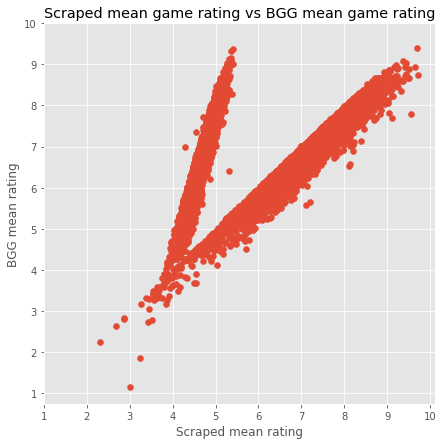

In [113]:
# add game metadata to the user rating data
# gameinfo.rename(columns={'id':'gameID'}, inplace=True)
# gbelow = games_below.merge(right=gameinfo, how='left', on='gameID')
# gabove = games_above.merge(right=gameinfo, how='left', on='gameID')

gm = gamegp.mean().reset_index().merge(right=gameinfo, how='left', on='gameID')

# scatter of calcuted mean vs BGG mean rating
plt.figure(figsize=(7,7))
plt.scatter(gm['rating'], gm['mean_rating'])
plt.title('Scraped mean game rating vs BGG mean game rating')
plt.xlabel('Scraped mean rating')
plt.ylabel('BGG mean rating')
# plt.legend()
plt.yticks([1,2,3,4,5,6,7,8,9,10]);
plt.xticks([1,2,3,4,5,6,7,8,9,10]);
plt.gcf().patch.set_facecolor('white'); # white background for copy


### Solution:

After reviewing the code I used for web scraping of ratings, I discovered a bug: after collecting ratings for all games in blocks of 250 games and 100 ratings each, the last remaining ratings are downloaded separately for each game. That is where the bugs was: it downloaded ratings for 250 games, and assigned them all to one game. This was done to only a subset of games since downloading continued between code edits.

### I fixed the code and re-scraped all game ratings:

- Most of the mean rescraped game ratings are now very close to the BGG mean ratings, and there is no second distribution. 


- However, there are a few outliers (deviations from the diagonal), which may be due to another smaller glitch in the download code (for example occasionally missing a page of ratings). I will revisit the code but this data seems good enough to use as-is.

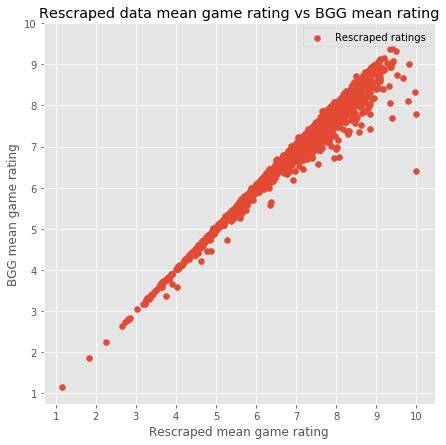

In [114]:
# load the rescraped boardgame user ratings data
rs_userdata = pd.read_csv(srcdir+'bgg_user_ratings_scrape_2.csv', 
                       encoding = "ISO-8859-1") 
rs_userdata = rs_userdata.rename(columns = {'username':'userID', 
                                    'gameid':'gameID'})
# rs_userdata = rs_userdata.drop_duplicates(subset=['gameID','userID'])

# calc game mean ratings from rescraped data
rs_gamegp = rs_userdata.groupby('gameID').mean().reset_index()

# add game metadata to the user rating data
rs_gamegp = rs_gamegp.merge(right=gameinfo, how='left', on='gameID')

# scatter of calcuted mean vs BGG mean rating
plt.figure(figsize=(7,7))
plt.scatter(rs_gamegp['rating'], rs_gamegp['mean_rating'], label='Rescraped ratings')
plt.title('Rescraped data mean game rating vs BGG mean rating')
plt.xlabel('Rescraped mean game rating')
plt.ylabel('BGG mean game rating')
plt.legend()
plt.gcf().patch.set_facecolor('white')
plt.yticks([1,2,3,4,5,6,7,8,9,10]);
plt.xticks([1,2,3,4,5,6,7,8,9,10]);


#good games = 11482
#bad games = 1118


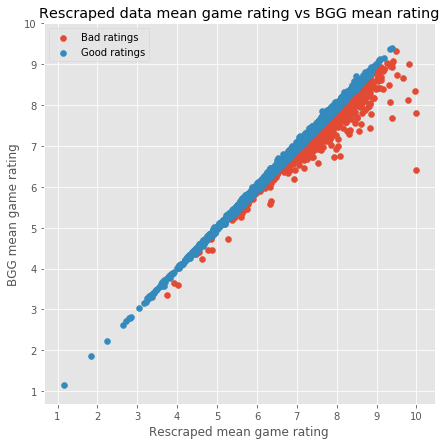

In [115]:
difthresh = .1

rs_game_gp_good = rs_gamegp[(rs_gamegp['rating'] - 
                           rs_gamegp['mean_rating']) <= difthresh]
rs_game_gp_bad = rs_gamegp[(rs_gamegp['rating'] - 
                           rs_gamegp['mean_rating']) > difthresh]

print('#good games =',rs_game_gp_good.shape[0])
print('#bad games =',rs_game_gp_bad.shape[0])

# scatter of calcuted mean vs BGG mean rating
plt.figure(figsize=(7,7))
plt.scatter(rs_game_gp_bad['rating'], rs_game_gp_bad['mean_rating'], 
            label='Bad ratings')
plt.scatter(rs_game_gp_good['rating'], rs_game_gp_good['mean_rating'], 
            label='Good ratings')
plt.title('Rescraped data mean game rating vs BGG mean rating')
plt.xlabel('Rescraped mean game rating')
plt.ylabel('BGG mean game rating')
plt.legend()
plt.gcf().patch.set_facecolor('white')
plt.yticks([1,2,3,4,5,6,7,8,9,10]);
plt.xticks([1,2,3,4,5,6,7,8,9,10]);


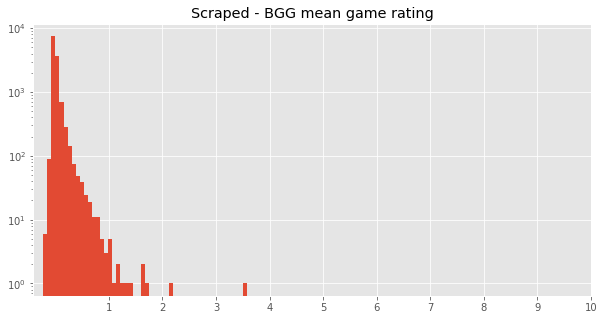

In [116]:
# histogram of BGG mean rating
plt.figure(figsize=(10,5))
plt.hist(rs_gamegp['rating']-rs_gamegp['mean_rating'], bins=50)
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.yscale('log')
plt.title('Scraped - BGG mean game rating');


In [117]:
gamelist = pd.read_csv(srcdir+'bgg_gamelist.csv')
gamelist.rename(columns={'id':'gameID'}, inplace=True)

games = rs_gamegp.merge(right=gamelist[
    ['gameID','nfullpages']], 
    how='left', on='gameID')

# #ratings mod 100 = #ratings in last page
games['last_page_n'] = np.mod(games['nrate'],100)

games['rating_dev'] = games['rating'] - games['mean_rating']


difthresh = .1

games_good = games[(games['rating'] - 
                    games['mean_rating']) <= difthresh]

games_bad = games[(games['rating'] - 
                   games['mean_rating']) > difthresh]



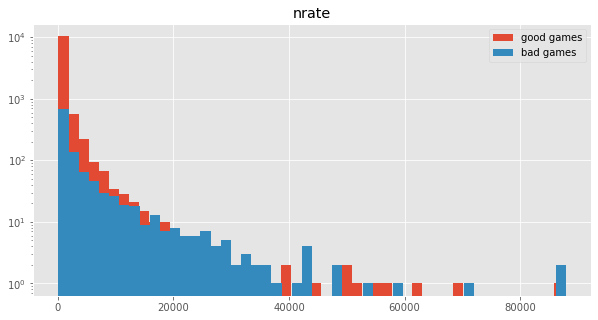

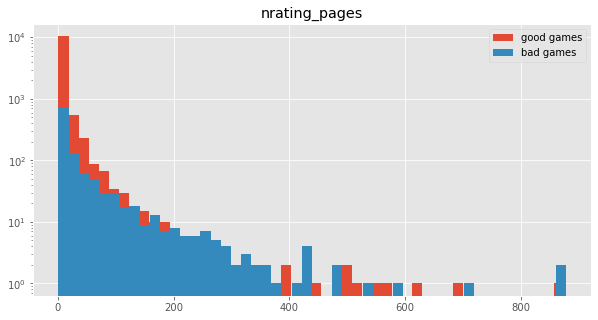

In [118]:
plt.figure(figsize=(10,5))
plt.hist(games_good['nrate'], bins=50, label='good games')
plt.hist(games_bad['nrate'], bins=50, label='bad games')
plt.title('nrate');
plt.yscale('log')
plt.legend();

plt.figure(figsize=(10,5))
plt.hist(games_good['nrating_pages'], bins=50, label='good games')
plt.hist(games_bad['nrating_pages'], bins=50, label='bad games')
plt.title('nrating_pages');
plt.yscale('log')
plt.legend();


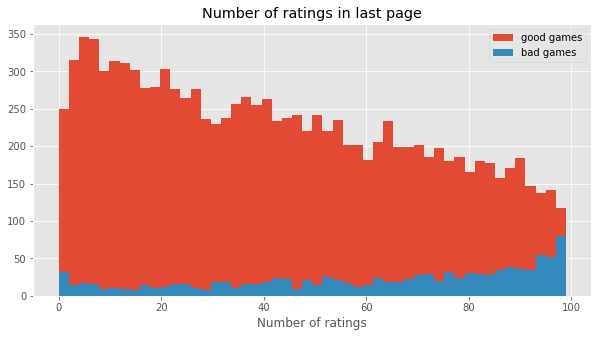

In [135]:
plt.figure(figsize=(10,5))
plt.hist(games_good['last_page_n'], bins=50, label='good games')
plt.hist(games_bad['last_page_n'], bins=50, label='bad games')
plt.gcf().patch.set_facecolor('white')
plt.title('Number of ratings in last page');
plt.xlabel('Number of ratings')
# plt.yscale('log')
plt.legend();


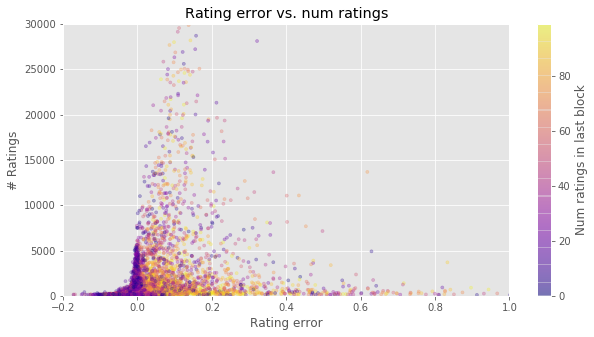

In [134]:
# scatter of calcuted mean vs BGG mean rating
plt.figure(figsize=(10,5))
cmap = 'plasma'
scat = plt.scatter(games['rating_dev'], games['nrate'], 
            c=games['last_page_n'], alpha=0.3, s=10,
            cmap=cmap)
plt.gcf().patch.set_facecolor('white')
ax = plt.gca()
cb = ax.figure.colorbar(scat, ax=ax, cmap=cmap)
cb.set_label('Num ratings in last block')
plt.xlabel('Rating error')
plt.xlim([-.2,1])
plt.ylim([0,30000])
plt.ylabel('# Ratings');
plt.title('Rating error vs. num ratings');


### Drop games with mean rating error > 0.2

There is still apparently a subtle bug in the ratings scraping script, but it seems to affect very few games and for now rather than spend time tracking it down, I will simply drop all games that have too large of a difference error between their mean BGG rating and the mean scraped rating. 

To determine what error threshold to use, I plotted number of games above error threshold vs threshold value, and selected the value at the inflection point of the curve - 0.25. This threshold resulted in a loss of 480 games from the dataset.


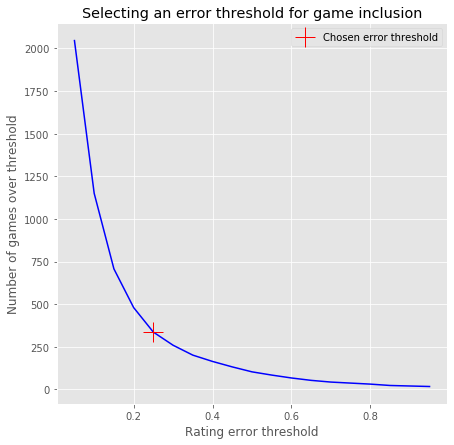

In [169]:
thresholds = list(np.arange(0.05,1,0.05))
ndropped = []
for thresh in thresholds:
    good_t = rs_gamegp[np.abs((rs_gamegp['rating'] - 
                           rs_gamegp['mean_rating'])) <= thresh]
    ndropped.append(rs_gamegp.shape[0]-good_t.shape[0])

plt.figure(figsize=(7,7))
plt.plot(threshholds, ndropped, 'b-')
plt.plot(thresholds[4],ndropped[4],'r+',markersize=20, 
         label='Chosen error threshold')
plt.title('Selecting an error threshold for game inclusion')
plt.xlabel('Rating error threshold')
plt.legend()
plt.ylabel('Number of games over threshold');
plt.gcf().patch.set_facecolor('white');


### Filter rating data to remove above threshold games

Save the filtered ratings as the final selection of uaser ratings.

In [172]:
difthresh = .25

included_games = rs_gamegp[np.abs((rs_gamegp['rating'] - 
                           rs_gamegp['mean_rating'])) <= difthresh]

print('games kept =',included_games.shape[0], 
      'dropped =',rs_gamegp.shape[0]-included_games.shape[0])

final_ratings = userdata.set_index('gameID').loc[
    included_games['gameID']].reset_index()

print('ratings kept =',final_ratings.shape[0],
     ' dropped =',userdata.shape[0]-final_ratings.shape[0])

final_ratings.head()


games kept = 12264 dropped = 336
ratings kept = 15142922  dropped = 544886


,gameID,userID,rating
0,1,jackcres,10.0
1,1,FuManchu,10.0
2,1,HankM,10.0
3,1,jonnypolite,10.0
4,1,pwotruba,10.0


In [166]:
outputpath = srcdir+'bgg_user_ratings_final.csv'

# save cleaned up dataframe to output file
final_ratings.to_csv(outputpath, index=False, encoding="ISO-8859-1")
